In [ ]:
import random as rd
import os
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

In [634]:
class femaleSimulateIBI:
    
    def __init__(self, f):
        
        self.ID = f
        self.status, self.cycleDay = "nonCycling", False
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.daysUntilCycling = randint(rangeOfNonCyclingDays+1)
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        self.genes = uniform(0,1)
        self.reproductiveSuccess = 0
        
    def switchToCycling(self):
            
        self.cycleDay = 0
        self.status = "cycling"
        self.daysUntilConception = round(normal(meanDaysToConception, sdDaysToConception))
        self.conceptionProbability = conceptionProbabilityList[0]
        
    def switchToDone(self):
        
        self.cycleDay = False
        self.status = "done"
        

In [635]:
class male:
    
    def __init__(self, m):
        
        self.ID = m
        self.fitness = uniform(0,1)
        self.genes = uniform(0,1)
        self.rank = self.fitness * self.genes
        self.cost = self.genes
        self.reproductiveSuccess = 0
        

In [742]:
class groupOfFemales:
    
    def __init__(self):

        self.rangeFemales = range(nFemales)
        self.rangeMales = range(nMales)
        self.listOfFemales = [femaleSimulateIBI(f) for f in self.rangeFemales]
        self.listOfMales = [male(m) for m in self.rangeMales]
        self.nAgents = nMales + nFemales
        self.modelDays = 0
        self.maleRanks()
        
        self.mutations = [round(uniform(0,self.nAgents * mutationRate * 2)) for i in range(nGenerations)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGenerations)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGenerations)
        
        self.generation = 0
    
    def go(self):
        
        for gen in range(nGenerations):
        
            self.generation += 1
            
            for r in range(10000):
                self.modelDays += 1
                if all([item.status =="done" for item in g.listOfFemales]):
                    break

                g.makeMatingPairs()

                for f in [item for item in g.listOfFemales if item.status == "cycling"]:
                    f.daysUntilConception -= 1
                    f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                    f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                    f.myConceptionProbabilityList += [f.conceptionProbability]
                    f.switchToDone() if f.daysUntilConception == 0 else 0

                for f in [item for item in g.listOfFemales if item.status == "nonCycling"]:
                    f.daysUntilCycling -= 1
                    f.myConceptionProbabilityList += [0]
                    f.switchToCycling() if f.daysUntilCycling <= 0 else 0

                for f in [item for item in g.listOfFemales if item.status == "done"]:
                    f.myConceptionProbabilityList += [0]
           
            print([round(m.genes,2) for m in g.listOfMales])
            print([round(m.rank,2) for m in g.listOfMales])
            print([round(m.reproductiveSuccess,2) for m in g.listOfMales])
                
            g.setupNextGen()
            g.maleRanks()
            g.setGenotypes()
    
    def maleRanks(self):
        
        self.listOfMales = sorted(self.listOfMales, key=self.sortRank, reverse = True)
        for m in self.rangeMales:
            self.listOfMales[m].rank = m
    
    def sortRank(self, m):
        return m.rank
    
    def makeMatingPairs(self):
        i = 0
        nPairs = len([item for item in g.listOfFemales if item.status == "cycling"])
        while i < nPairs:
            self.listOfMales[i].reproductiveSuccess += self.listOfFemales[i].conceptionProbability * self.listOfMales[i].fitness
            #self.males[i].mateTiming.append(self.females[f].cycleDay)
            self.listOfFemales[i].reproductiveSuccess += self.listOfFemales[i].conceptionProbability * self.listOfMales[i].fitness
            i += 1
        
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess for f in self.listOfFemales]
        # lack of ability to chose becomes a cost as rankFitnessCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = [m.reproductiveSuccess  - m.cost for m in self.listOfMales] # does male fitness matter?
            
        parentsStartingPoint = self.generation * self.nAgents
        
        moms = [rdchoices(self.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in self.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (self.nAgents * 3), 3)]
        dads = [rdchoices(self.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in self.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (self.nAgents * 3), 3)]
        print(dads)
        
        self.nextGenMotherGenes = [self.listOfFemales[m].genes for m in moms]
        self.nextGenFatherGenes = [self.listOfMales[d].genes for d in dads]
        
        self.offspringGenes = choice(self.nextGenMotherGenes + self.nextGenFatherGenes, self.nAgents, replace=False)

        #self.recombination()
        self.mutation() if self.mutations[self.generation - 1] > 0 else 0
        self.reset()
        
    def mutation(self):
        
        genesInGroup =  self.nAgents
        mutations = self.mutations[self.generation - 1]
        
        offspringsMutating = choice(range(self.nAgents), mutations, replace=False)

        pertubations = choice([-0.02,0.02], mutations)
        
        newGenes = nparray([self.offspringGenes[offspringsMutating[m]] + pertubations[m] for m in range(mutations)])
                
        newGenes[newGenes > 1] = 1
        newGenes[newGenes < 0] = 0
        
    def setGenotypes(self):
        
        for f in self.listOfFemales:
            f.genes = self.offspringGenes[f.ID]
            f.cost = f.genes

        for m in self.listOfMales:
            m.genes = self.offspringGenes[m.rank + nFemales]
            
    def reset(self):
        self.modelDays = 0
        self.listOfMales, self.listOfFemales = [], []
        self.listOfMales = [male(m) for m in range(nMales)]
        self.listOfFemales = [femaleSimulateIBI(f) for f in range(nFemales)]
        

In [743]:
seasonality = 0.0

meanDaysToConception = 60
sdDaysToConception = 10

nGenerations = 200
mutationRate = 0.01

nFemales = 10
nMales = 10
#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)
g = groupOfFemales()

g.go()

[0.9616540845322085, 0.8207364514470545, 0.5981742374643046, 0.9420256352686964, 0.6030338379829442, 0.5280450181651881, 0.7519106658570865, 0.9373094813957251, 0.0842704272692435, 0.1506261825706734]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.4183064002115904, 2.0847507764347886, 0.8191435116609642, 0.0, 0.0, 0, 0, 0, 0, 0]
[2, 6, 6, 1, 6, 3, 3, 0, 8, 0, 1, 8, 6, 1, 8, 6, 5, 5, 9, 0]
[0.40415513021496385, 0.7201708167513308, 0.7273259339966944, 0.7273259339966944, 0.7201708167513308, 0.7201708167513308, 0.8207364514470545, 0.7519106658570865, 0.7519106658570865, 0.5280450181651881]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[17.51967944697247, 1.638393074532185, 0.7315863177793335, 0.0, 0.0, 0, 0, 0, 0, 0]
[5, 0, 0, 7, 9, 7, 1, 5, 4, 8, 5, 0, 0, 4, 9, 2, 1, 2, 9, 3]
[0.7201708167513308, 0.11451805452596486, 0.7201708167513308, 0.0842704272692435, 0.7519106658570865, 0.40415513021496385, 0.7201708167513308, 0.40415513021496385, 0.11451805452596486, 0.9616540845322085]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[45.803

[9, 7, 4, 0, 8, 6, 9, 2, 1, 2, 7, 9, 8, 8, 9, 0, 3, 0, 4, 2]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.8472787408756561, 0.8697532497536015, 0.48806744857126644, 0.6039343470892209, 0, 0, 0, 0, 0, 0]
[2, 1, 5, 4, 3, 3, 3, 6, 0, 6, 0, 8, 3, 1, 3, 3, 0, 8, 6, 6]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[7.626029124362266, 1.2641082567667727, 0.43727762264871706, 1.442575336867626, 0, 0, 0, 0, 0, 0]
[5, 0, 0, 3, 1, 3, 1, 3, 1, 9, 8, 3, 6, 1, 2, 6, 8, 0, 2, 3]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.114518

[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2.436674794956695, 6.448498710711055, 0.7411174724406197, 0.9060908220205891, 0.7193895341316697, 0, 0, 0, 0, 0]
[5, 4, 7, 3, 1, 1, 1, 3, 1, 0, 0, 3, 0, 8, 4, 6, 0, 0, 6, 1]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2.163437199264012, 1.7133543038010426, 2.515965242029993, 0.3658816825851573, 0, 0, 0, 0, 0, 0]
[3, 5, 0, 0, 9, 8, 9, 8, 2, 2, 0, 5, 0, 9, 0, 7, 1, 9, 0, 3]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.114518054525

[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.8261985911032288, 2.0171215379499134, 0.7825058833315377, 0, 0, 0, 0, 0, 0, 0]
[9, 8, 9, 9, 4, 0, 3, 1, 9, 0, 2, 2, 6, 0, 0, 9, 1, 9, 3, 0]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.75716305095678, 11.214065585658295, 0.7950457189414338, 0.0, 0, 0, 0, 0, 0, 0]
[9, 9, 5, 2, 1, 6, 0, 1, 9, 6, 2, 6, 0, 2, 0, 2, 8, 2, 6, 7]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 

[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.8443441974668688, 1.9315116178918765, 0.36416164387011074, 0, 0, 0, 0, 0, 0, 0]
[1, 8, 4, 7, 1, 3, 9, 7, 4, 8, 4, 0, 7, 1, 7, 2, 9, 6, 7, 3]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2.9283409061137196, 1.0389969820910545, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0]
[7, 7, 1, 2, 0, 7, 1, 5, 7, 1, 8, 4, 1, 1, 8, 5, 1, 2, 8, 8]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9

[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.8866124785444471, 0.0, 0.7393829792658059, 0, 0, 0, 0, 0, 0, 0]
[9, 0, 7, 6, 3, 2, 0, 0, 4, 4, 4, 8, 3, 8, 3, 6, 1, 3, 4, 5]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7526165421909609, 0.0, 0.22706772476574286, 0.0, 0, 0, 0, 0, 0, 0]
[0, 9, 5, 4, 7, 9, 8, 3, 9, 0, 5, 0, 9, 7, 5, 8, 6, 4, 4, 0]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.467946553934

[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.5069315782162973, 0.5773574437993806, 1.0872814865979883, 0.0, 0.09942029361509655, 0, 0, 0, 0, 0]
[1, 4, 7, 7, 7, 0, 2, 2, 1, 9, 2, 2, 2, 0, 7, 0, 9, 5, 0, 3]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1.2705132327978095, 0.6321898747021181, 0.21538249971643617, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 0, 8, 7, 2, 0, 7, 0, 9, 0, 0, 7, 0, 0, 0, 1, 1, 1, 8]
[0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486, 0.11451805452596486

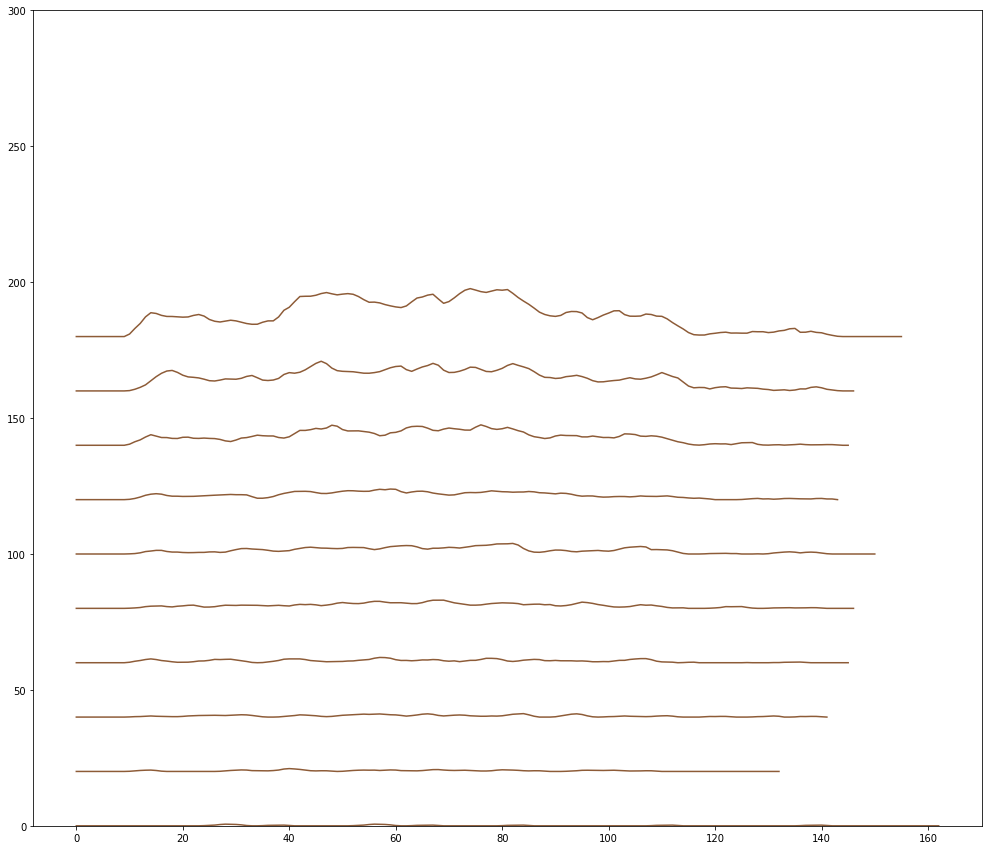

In [731]:
nFemales = 5
nMales = 5
seasonality = 0.8

meanDaysToConception = 60
sdDaysToConception = 10

cycleLength = 28
ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post

nGenerations = 200
mutationRate = 0.01

palette = np.flip(sns.color_palette("viridis",350))

plt.figure(figsize=(17, 15))
#for s in arange(0.0, 1.1, 0.1):
a = 0
for n in [5,15,25,40,65,85,100,200,300,500]:
    nFemales = n
    nMales = n
    #seasonality = s
    rangeOfNonCyclingDays = 365 - (365 * seasonality)
    g = groupOfFemales()
    g.go()

    totalProb = [0] * g.modelDays
    for i in range(g.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) + a*20

    allDaysTotal = plt.plot(range(g.modelDays), totalProb, color = palette[round(s*250)])
    plt.ylim([0,300])
    
    a += 1

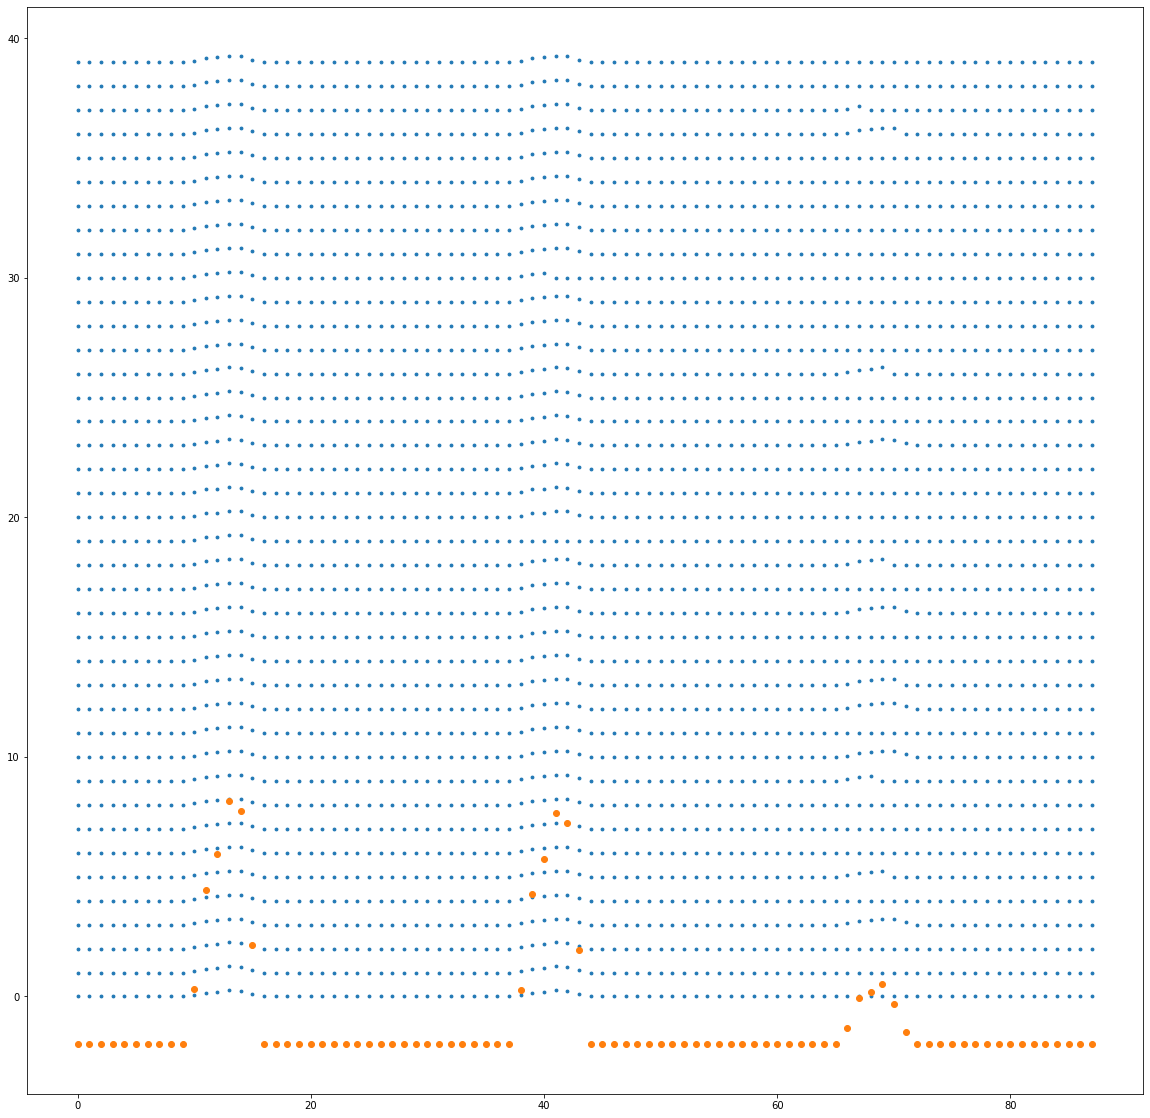

In [733]:
nFemales = 40
seasonality = 1.0

meanDaysToConception = 60
sdDaysToConception = 10

rangeOfNonCyclingDays = 365 - (365 * seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


g = groupOfFemales()
g.go()
    
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(g.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(g.modelDays)]
                                   for f in g.listOfFemales], s=8)

totalProb = [0] * g.modelDays
for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) - 2
    
allDaysTotal = plt.scatter([range(g.modelDays)], totalProb)



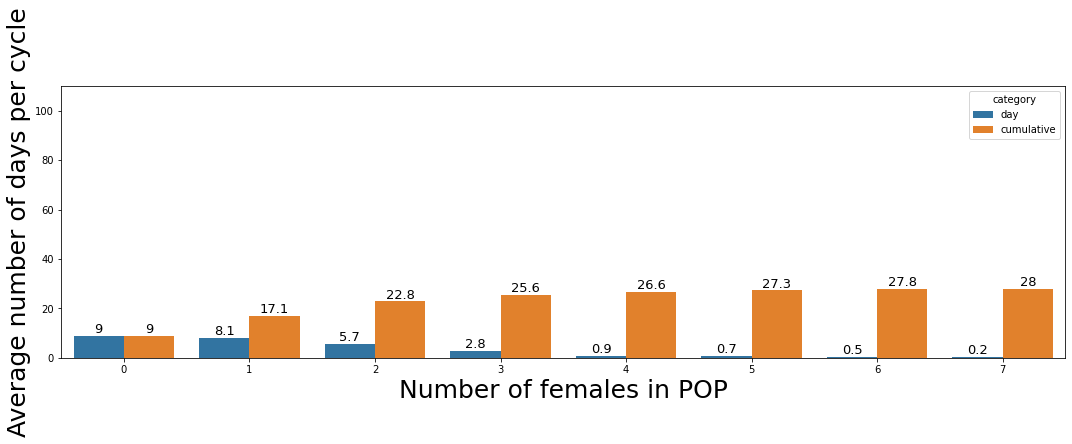

In [589]:
groupConceptionProbabilities = []
lenFertilePerDay = len(fertilePerDay)

for d in range(g.modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / g.modelDays for i in range(nFemales + 1)]

for day in np.flip(range(len(fertilePerDay))):
    if fertilePerDay[day] ==  0:
        fertilePerDay.pop(day)
    else:
        break

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / g.modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "category"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])

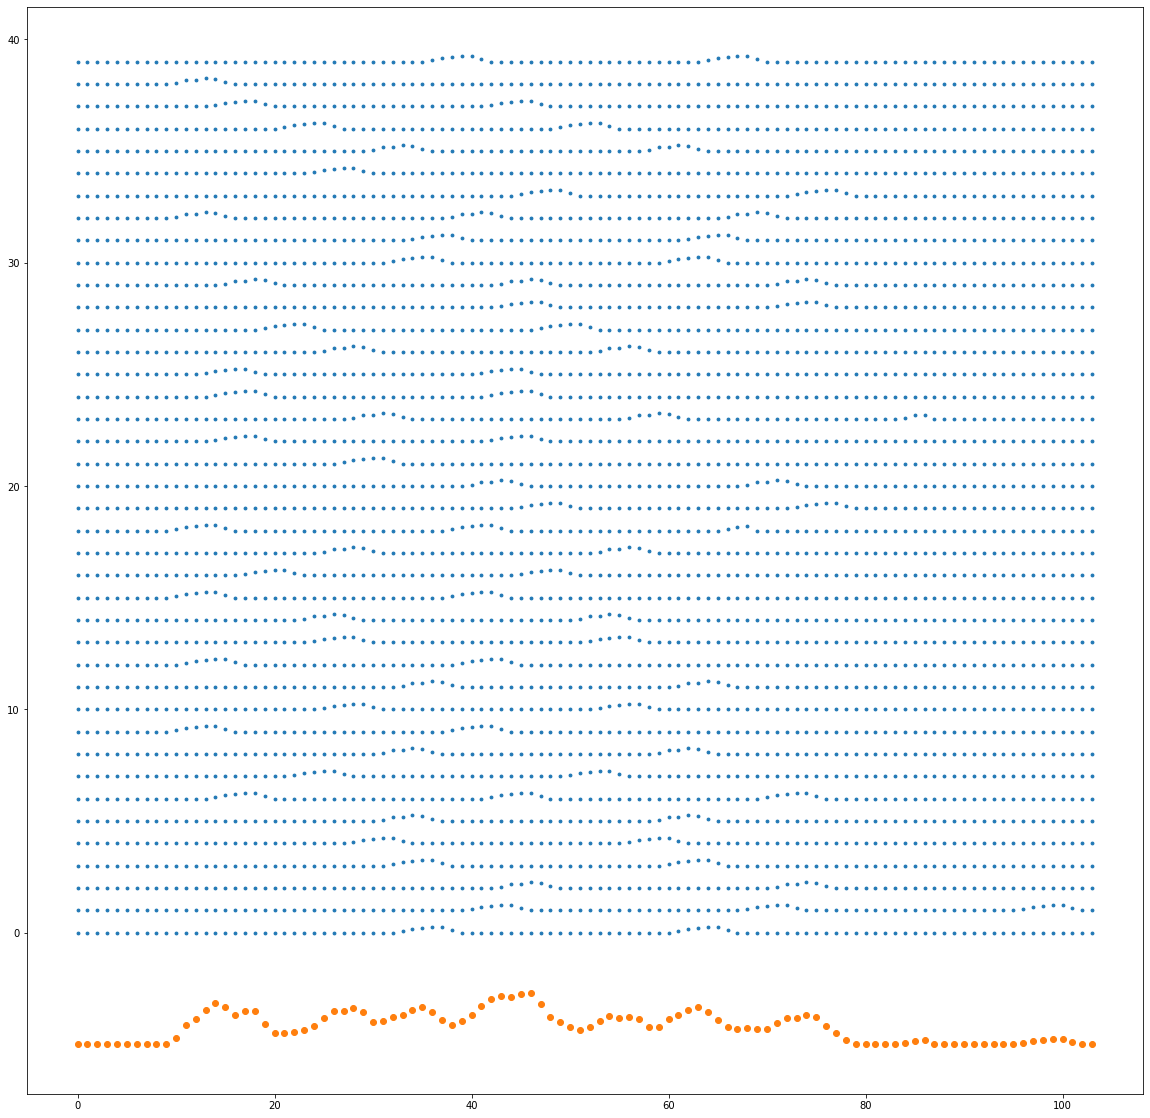

In [592]:
nFemales = 40
nMales = 40
seasonality = 0.9

meanDaysToConception = 60
sdDaysToConception = 10

rangeOfNonCyclingDays = 365 - (365 * seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post

g = groupOfFemales()
g.go()

totalProb = [0] * g.modelDays
for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales])
    
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(g.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(g.modelDays)]
                                   for f in g.listOfFemales], s=8)

totalProb = [0] * g.modelDays
for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) - 5
    
allDaysTotal = plt.scatter([range(g.modelDays)], totalProb)


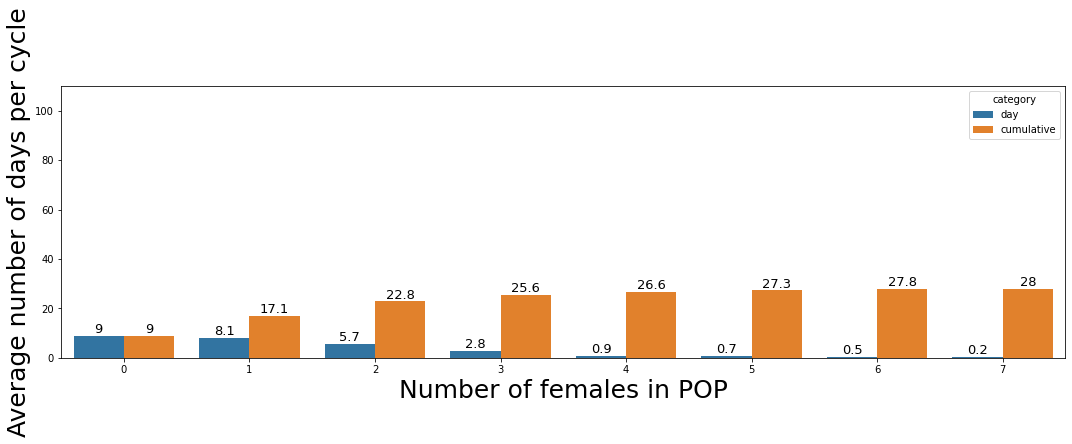

In [590]:
groupConceptionProbabilities = []
lenFertilePerDay = len(fertilePerDay)

for d in range(g.modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / g.modelDays for i in range(nFemales + 1)]

for day in np.flip(range(len(fertilePerDay))):
    if fertilePerDay[day] ==  0:
        fertilePerDay.pop(day)
    else:
        break

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / g.modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "category"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])